In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read
import sys

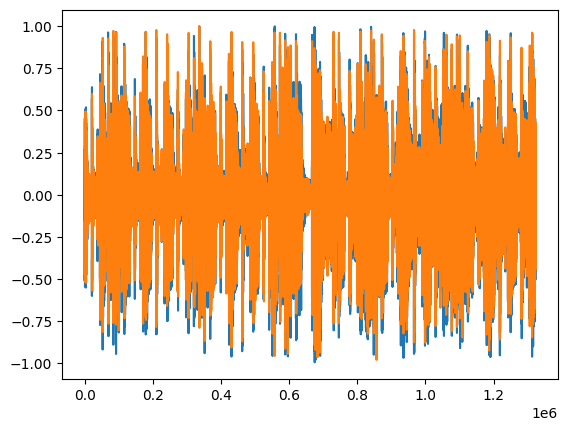

In [2]:
rate, file = read("Protection.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

start = 10
end = 40
data0 = data0[start * rate : end * rate]
data1 = data1[start * rate : end * rate]

plt.plot(data0)
plt.plot(data1)
plt.show()

In [3]:
class Biquad:
    def __init__(self, b0, b1, b2, a0, a1, a2):
        # Filter coefficients
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a0 = a0
        self.a1 = a1
        self.a2 = a2

        # State variables
        self.x1 = self.x2 = self.y1 = self.y2 = 0.0

    def process(self, x):
        # Direct Form II implementation
        w = x - self.a1 * self.x1 - self.a2 * self.x2
        y = self.b0 * w + self.b1 * self.x1 + self.b2 * self.x2

        # Update state variables
        self.x2 = self.x1
        self.x1 = w
        self.y2 = self.y1
        self.y1 = y

        return y

def Pan(L, R, factor, mode):
    if mode == 0:
        return L * factor, R * (1 - factor)
    if mode == 1:
        return L * np.sqrt(factor), R * np.sqrt(1 - factor)
    if mode == 2:
        return L * np.sin(factor * np.pi / 2), R * np.sin((1 - factor) * np.pi / 2)

def decode(data0, data1):
    C = np.zeros(data0.size)
    S = np.zeros(data1.size)
    
    Panning = 0.5
    CB = np.array([0.5, 0.5])
    
    b = [3.844633506779265e-06, 7.68926701355853e-06, 3.844633506779265e-06]
    a = [1.0, -1.9944464105419266, 0.9944617890759537]
    
    biquad = Biquad(b[0], b[1], b[2], a[0], a[1], a[2])
    
    for index, data in enumerate(zip(data0, data1)):
        L = data[0]
        R = data[1]

        VCA_L, VCA_R = Pan(L, R, Panning, 2)

        C[index] = VCA_L + VCA_R
        S[index] = VCA_L - VCA_R

        FWR_L = np.abs(VCA_L)
        FWR_R = np.abs(VCA_R)
        
        E = FWR_L + FWR_R
        
        flag = np.float32(FWR_L * FWR_R > 0)
        Panning = biquad.process(flag * np.divide(FWR_R, E, out=np.zeros_like(FWR_R), where=E!=0) + (1 - flag) * Panning)
    return C, S

In [4]:
factor = np.sqrt(2)/2

# C, S = decode(data0, data1)
# LC, LS = decode(data0, C * factor)
# RC, RS = decode(data1, C * factor)

# write("C.wav",  rate, (C  * 32767.0 * factor).astype(np.int16))
# write("S.wav",  rate, (S  * 32767.0 * factor).astype(np.int16))
# write("LS.wav", rate, (LS * 32767.0 * factor).astype(np.int16))
# write("RS.wav", rate, (RS * 32767.0 * factor).astype(np.int16))
# write("LC.wav", rate, (LC * 32767.0 * factor).astype(np.int16))
# write("RC.wav", rate, (RC * 32767.0 * factor).astype(np.int16))

# IPython.display.display(IPython.display.Audio("C.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("S.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("LS.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("RS.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("LC.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("RC.wav", rate=rate))

In [5]:
def LinkwitzRiley24dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosinePmega = np.cos(omega)
    alpha = sineOmega * np.sqrt(2) / 2
    a0 = 1 + alpha
    
    A1 = -( 2 * cosinePmega) / a0
    A2 = (1 - alpha) / a0
    B1 = (1 - cosinePmega) / a0 
    B0 = B1 / 2
    B2 = B0
    
    b_lp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_lp = np.convolve([1, A1, A2], [1, A1, A2])
    
    A1 = -(2 * cosinePmega) / a0
    A2 = (1 - alpha) / a0
    B1 = -(1 + cosinePmega) / a0
    B0 = -B1 / 2
    B2 = B0
    
    b_hp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_hp = np.convolve([1, A1, A2], [1, A1, A2])
    
    return [b_lp, a_lp], [b_hp, a_hp]

In [6]:
fs = 48000
length = 8192

fc1 = 500
fc2 = 1000
fc3 = 2000

F1, F1_ = LinkwitzRiley24dB(fc1, fs)
F2, F2_ = LinkwitzRiley24dB(fc2, fs)
F3, F3_ = LinkwitzRiley24dB(fc3, fs)
A1 = [F1[0] + F1_[0], F1_[1]]
A3 = [F3[0] + F3_[0], F3_[1]]

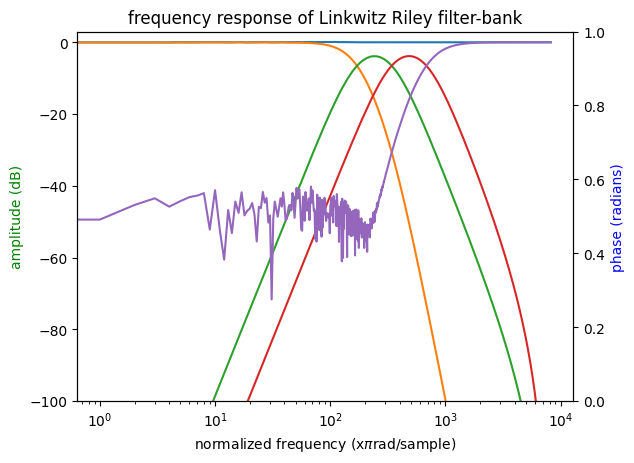

In [7]:
def _coefficient_convolve(h1, h2):
    return np.convolve(h1[0], h2[0]), np.convolve(h1[1], h2[1])

B0 = _coefficient_convolve(_coefficient_convolve(F2,  F1), A3)
B1 = _coefficient_convolve(_coefficient_convolve(F2,  F1_), A3)
B2 = _coefficient_convolve(_coefficient_convolve(F3,  F2_), A1)
B3 = _coefficient_convolve(_coefficient_convolve(F3_, F2_), A1)

w, f1 = signal.freqz(B0[0], B0[1], length)
w, f2 = signal.freqz(B1[0], B1[1], length)
w, f3 = signal.freqz(B2[0], B2[1], length)
w, f4 = signal.freqz(B3[0], B3[1], length)

amplitude  = 20 * np.log10(abs(f1+f2+f3+f4))
amplitude1 = 20 * np.log10(abs(f1))
amplitude2 = 20 * np.log10(abs(f2))
amplitude3 = 20 * np.log10(abs(f3))
amplitude4 = 20 * np.log10(abs(f4))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(amplitude)
ax1.plot(amplitude1)
ax1.plot(amplitude2)
ax1.plot(amplitude3)
ax1.plot(amplitude4)

ax1.set_ylim(-100, 3)

plt.title('frequency response of Linkwitz Riley filter-bank')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax2.set_ylabel('phase (radians)', color='b')
plt.xscale('log')
plt.show()

In [8]:
L0 = signal.lfilter(B0[0], B0[1], data0)
L1 = signal.lfilter(B1[0], B1[1], data0)
L2 = signal.lfilter(B2[0], B2[1], data0)
L3 = signal.lfilter(B3[0], B3[1], data0)

R0 = signal.lfilter(B0[0], B0[1], data1)
R1 = signal.lfilter(B1[0], B1[1], data1)
R2 = signal.lfilter(B2[0], B2[1], data1)
R3 = signal.lfilter(B3[0], B3[1], data1)

In [9]:
C0,  S0  = decode(L0, R0)
# LC0, LS0 = decode(L0, C0 * factor)
# RC0, RS0 = decode(R0, C0 * factor)

C1,  S1  = decode(L1, R1)
# LC1, LS1 = decode(L1, C1 * factor)
# RC1, RS1 = decode(R1, C1 * factor)

C2,  S2  = decode(L2, R2)
# LC2, LS2 = decode(L2, C2 * factor)
# RC2, RS2 = decode(R2, C2 * factor)

C3,  S3  = decode(L3, R3)
# LC3, LS3 = decode(L3, C3 * factor)
# RC3, RS3 = decode(R3, C3 * factor)

In [10]:
write("C.wav",  rate, ((C0+C1+C2+C3) * 32767.0 * factor).astype(np.int16))
write("S.wav",  rate, ((S0+S1+S2+S3) * 32767.0 * factor).astype(np.int16))
# write("LS.wav", rate, ((LS0+LS1+LS2+LS3) * 32767.0 * factor).astype(np.int16))
# write("RS.wav", rate, ((RS0+RS1+RS2+RS3) * 32767.0 * factor).astype(np.int16))
# write("LC.wav", rate, ((LC0+LC1+LC2+LC3) * 32767.0 * factor * factor).astype(np.int16))
# write("RC.wav", rate, ((RC0+RC1+RC2+RC3) * 32767.0 * factor * factor).astype(np.int16))

IPython.display.display(IPython.display.Audio("C.wav", rate=rate))
IPython.display.display(IPython.display.Audio("S.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("LS.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("RS.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("LC.wav", rate=rate))
# IPython.display.display(IPython.display.Audio("RC.wav", rate=rate))